<a href="https://colab.research.google.com/github/geekevgin/-Python/blob/main/BelEvSer_NLP_HW_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import SimpleRNN, LSTM, Bidirectional, GRU

import unicodedata
import re
import numpy as np
import os
import io
import time

In [ ]:
batch_size = 1024
epochs = 100
latent_dim = 256
num_samples = 30000

In [ ]:
!wget http://www.manythings.org/anki/fra-eng.zip

--2023-05-27 07:57:05--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7420323 (7.1M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.08M  18.9MB/s    in 0.4s    

2023-05-27 07:57:05 (18.9 MB/s) - ‘fra-eng.zip’ saved [7420323/7420323]



In [ ]:
!mkdir fra-eng
!unzip fra-eng.zip -d fra-eng/

Archive:  fra-eng.zip
  inflating: fra-eng/_about.txt      
  inflating: fra-eng/fra.txt         


In [ ]:
!ls /content/fra-eng/ -lah

total 32M
drwxr-xr-x 2 root root 4.0K May 27 07:59 .
drwxr-xr-x 1 root root 4.0K May 27 07:59 ..
-rw-r--r-- 1 root root 1.5K Apr  2 03:16 _about.txt
-rw-r--r-- 1 root root  32M Apr  2 03:16 fra.txt


In [ ]:
import re
import tensorflow as tf
data_path = '/content/fra-eng/fra.txt'
num_samples = 20000


input_texts = []
target_texts = []


In [ ]:
def preprocess_sentence(w): #Предобработка пунктуации, последовательности
        
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Zа-яА-Я]+", " ", w)
    w = w.strip()
    w = '<start> ' + w + ' <end>'
    return w

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    target_text = '\t' + target_text + '\n'
    input_texts.append(preprocess_sentence(input_text))
    target_texts.append(preprocess_sentence(target_text))

In [ ]:
input_texts[:4], target_texts[:4]

(['<start> Go <end>',
  '<start> Go <end>',
  '<start> Go <end>',
  '<start> Go <end>'],
 ['<start> Va <end>',
  '<start> Marche <end>',
  '<start> En route <end>',
  '<start> Bouge <end>'])

In [ ]:
lines[:10]

['Go.\tVa !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)',
 'Go.\tMarche.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)',
 'Go.\tEn route !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8267435 (felix63)',
 'Go.\tBouge !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)',
 'Hi.\tSalut !\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)',
 'Hi.\tSalut.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)',
 'Run!\tCours\u202f!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906331 (sacredceltic)',
 'Run!\tCourez\u202f!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906332 (sacredceltic)',
 'Run!\tPrenez vos jambes à vos cous !\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #2077449 (sacredceltic)',
 'Run!\tFile !\tCC-BY 2.0 (France) Attribution: tatoeba.org #90

In [ ]:
inp, truth, _ = lines[0].split("\t")
print("input:", inp)
print("groundtruth:", truth)
print("-", _)

input: Go.
groundtruth: Va !
- CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)


In [ ]:
preprocess_sentence(inp), preprocess_sentence(truth)

('<start> Go <end>', '<start> Va <end>')

In [ ]:
def tokenize(lang:list): #Токенизация текста
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
    return tensor, lang_tokenizer

In [ ]:
input_tensor, inp_lang_tokenizer = tokenize(input_texts)
target_tensor, targ_lang_tokenizer = tokenize(target_texts)

In [ ]:
from sklearn.model_selection import train_test_split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = batch_size
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024

vocab_inp_size = len(inp_lang_tokenizer.word_index)+1
vocab_tar_size = len(targ_lang_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [89]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True)
        self.gru = tf.keras.layers.Bidirectional(GRU(self.enc_units,
                                   return_sequences=False,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform'))

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.lstm(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))


In [90]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights
    

In [91]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.lstm(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attention_weights

In [92]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [93]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)
    
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [94]:
for epoch in range(epochs):
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))

Epoch 1 Loss 2.2621
Epoch 2 Loss 1.7856
Epoch 3 Loss 1.6906
Epoch 4 Loss 1.5882
Epoch 5 Loss 1.5036
Epoch 6 Loss 1.4343
Epoch 7 Loss 1.3743
Epoch 8 Loss 1.3096
Epoch 9 Loss 1.2387
Epoch 10 Loss 1.1796
Epoch 11 Loss 1.1414
Epoch 12 Loss 1.0885
Epoch 13 Loss 1.0444
Epoch 14 Loss 1.0017
Epoch 15 Loss 0.9617
Epoch 16 Loss 0.9200
Epoch 17 Loss 0.8825
Epoch 18 Loss 0.8426
Epoch 19 Loss 0.8064
Epoch 20 Loss 0.7739
Epoch 21 Loss 0.7436
Epoch 22 Loss 0.7134
Epoch 23 Loss 0.6801
Epoch 24 Loss 0.6501
Epoch 25 Loss 0.6232
Epoch 26 Loss 0.5996
Epoch 27 Loss 0.5701
Epoch 28 Loss 0.5444
Epoch 29 Loss 0.5203
Epoch 30 Loss 0.4944
Epoch 31 Loss 0.4711
Epoch 32 Loss 0.4497
Epoch 33 Loss 0.4274
Epoch 34 Loss 0.4035
Epoch 35 Loss 0.3808
Epoch 36 Loss 0.3629
Epoch 37 Loss 0.3438
Epoch 38 Loss 0.3260
Epoch 39 Loss 0.3111
Epoch 40 Loss 0.2941
Epoch 41 Loss 0.2813
Epoch 42 Loss 0.2667
Epoch 43 Loss 0.2538
Epoch 44 Loss 0.2435
Epoch 45 Loss 0.2325
Epoch 46 Loss 0.2234
Epoch 47 Loss 0.2130
Epoch 48 Loss 0.2045
E

In [95]:
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

from matplotlib import pyplot as plt
from matplotlib import ticker

def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    inputs = [inp_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang_tokenizer.index_word[predicted_id] + ' '

        if targ_lang_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
    
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))


Input: <start> it s nice here <end>
Predicted translation: c est l argent <end> 


<ipython-input-95-1342b1be7137>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-95-1342b1be7137>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


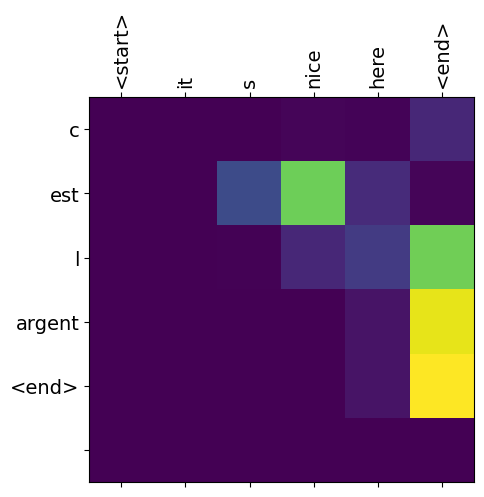

In [96]:
translate("it's nice here")

Input: <start> i can t go <end>
Predicted translation: je ne peux pas y aller <end> 


<ipython-input-95-1342b1be7137>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-95-1342b1be7137>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


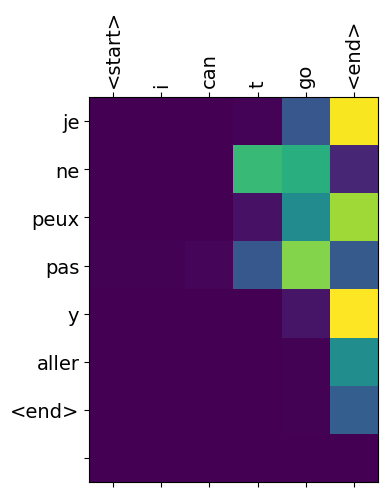

In [97]:
translate("i can't go")

Input: <start> are you still at home <end>
Predicted translation: tu es encore comment <end> 


<ipython-input-95-1342b1be7137>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-95-1342b1be7137>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


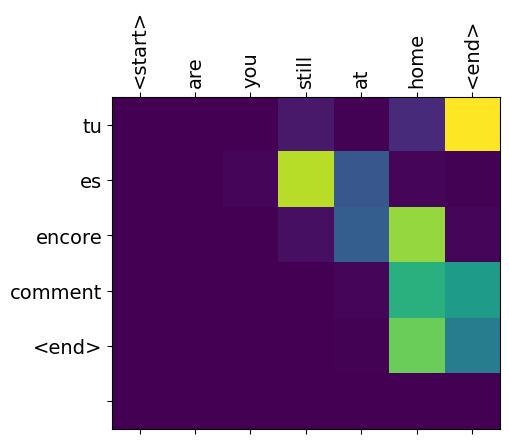

In [98]:
translate("are you still at home?")

Input: <start> i like rain <end>
Predicted translation: mangez vos petits <end> 


<ipython-input-95-1342b1be7137>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-95-1342b1be7137>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


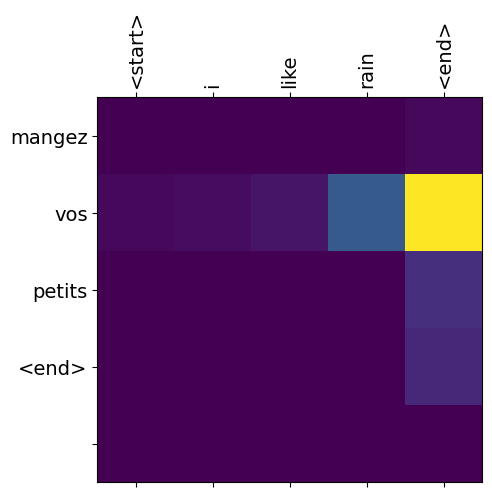

In [99]:
translate("i like rain")